In [20]:
'''A jupyter notebook comparing the forecast under daily conditioning to the forecasting under weekly conditioning. '''

'A jupyter notebook comparing the forecast under daily conditioning to the forecasting under weekly conditioning. '

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import RandomLocationsAndRandomSeed

from epymorph.adrio import us_tiger

from epymorph.forecasting.pipeline import (
    FromRUME,FromOutput,
    ParticleFilterSimulator,ForecastSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.forecasting.likelihood import Poisson,NegativeBinomial
from epymorph.forecasting.dynamic_params import BrownianMotion,OrnsteinUhlenbeck
from epymorph.forecasting.dynamic_params import GaussianPrior
from epymorph.forecasting.param_transformations import ExponentialTransform

from epymorph.time import EveryNDays

In [22]:
states = ["AZ", "CO", "NM", "NV"]

cutoff_week = 12

full_time_frame = TimeFrame.of("2022-09-15", 7 * 26 + 1)
pf_time_frame = TimeFrame.of("2022-09-15", 7 * cutoff_week)

rume = SingleStrataRUME.build(
    ipm=ipm.SIRH(),
    mm=mm.No(),
    scope=StateScope.in_states(states, year=2015),
    init=RandomLocationsAndRandomSeed(
        num_locations=len(states),
        seed_max=10_000
    ),
    time_frame=pf_time_frame,
    params={
        "beta": ExponentialTransform('log_beta'),
        "gamma": 0.2,
        "xi": 1 / 365,
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
        "phi":10,
        "commuter_proportion":0.30,
        "centroid": us_tiger.InternalPoint(),
    },
)

<Axes: xlabel='date', ylabel='value'>

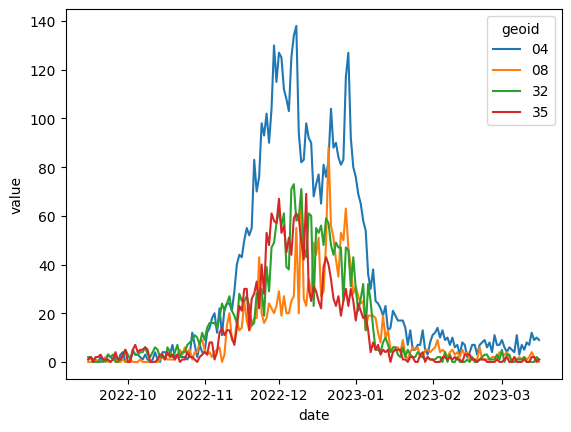

In [23]:
import seaborn as sns
import pandas as pd

columns = ['date','state','previous_day_admission_influenza_confirmed']

csv_data = pd.read_csv('pf_vignettes/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv')

df = csv_data[csv_data['state'].isin(states)][columns].copy()
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')
df = df.reset_index(drop = True)

date_range = full_time_frame.to_date_range().to_pandas()
df = df[df['date'].isin(date_range)][columns]

df_data = df.copy()

df_data.columns = ['date','geoid','value']

state_mapping = {state:id for state,id in zip(states,rume.scope.node_ids)}
df_data['geoid'] = df_data['geoid'].map(state_mapping)

df_data.to_csv(f'./pf_vignettes/daily_data_SW.csv',index = False)

sns.lineplot(data=df_data,x='date',y='value',hue='geoid')

In [24]:
from epymorph.adrio import csv

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/daily_data_SW.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [25]:


observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I->H"),
        time=rume.time_frame.select.all().group(EveryNDays(1)).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=NegativeBinomial(r=10),
)

In [26]:
num_realizations = 200

unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=np.log(0.25),
            standard_deviation=0.2,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=1/35,
            mean=np.log(0.25),
            standard_deviation=0.2,
        ),
    )
}

particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations,
        save_trajectories=True,
    )

In [27]:
rng = np.random.default_rng(0)
particle_filter_output = particle_filter_simulator.run(rng=rng)

Observation: 0, Label: 2022-09-15, Time Frame: 2022-09-15 (1D), 
Observation: 1, Label: 2022-09-16, Time Frame: 2022-09-16 (1D), 
Observation: 2, Label: 2022-09-17, Time Frame: 2022-09-17 (1D), 
Observation: 3, Label: 2022-09-18, Time Frame: 2022-09-18 (1D), 
Observation: 4, Label: 2022-09-19, Time Frame: 2022-09-19 (1D), 
Observation: 5, Label: 2022-09-20, Time Frame: 2022-09-20 (1D), 
Observation: 6, Label: 2022-09-21, Time Frame: 2022-09-21 (1D), 
Observation: 7, Label: 2022-09-22, Time Frame: 2022-09-22 (1D), 
Observation: 8, Label: 2022-09-23, Time Frame: 2022-09-23 (1D), 
Observation: 9, Label: 2022-09-24, Time Frame: 2022-09-24 (1D), 
Observation: 10, Label: 2022-09-25, Time Frame: 2022-09-25 (1D), 
Observation: 11, Label: 2022-09-26, Time Frame: 2022-09-26 (1D), 
Observation: 12, Label: 2022-09-27, Time Frame: 2022-09-27 (1D), 
Observation: 13, Label: 2022-09-28, Time Frame: 2022-09-28 (1D), 
Observation: 14, Label: 2022-09-29, Time Frame: 2022-09-29 (1D), 
Observation: 15, Lab

In [28]:
from epymorph.forecasting.pipeline import FromOutput

extend_duration = 28 #Days

forecast_simulator = ForecastSimulator(FromOutput(particle_filter_output,extend_duration))

In [29]:
forecast_output = forecast_simulator.run(rng=rng)

In [30]:
tf = TimeFrame.of("2022-09-15", 7 * cutoff_week + extend_duration).to_date_range().to_pandas()

columns = ['date','state','total_patients_hospitalized_confirmed_influenza']

df_hosp = csv_data[csv_data['state'].isin(states)][columns].copy()
df_hosp['date'] = pd.to_datetime(df_hosp['date'])

df_hosp = df_hosp.sort_values('date')
df_hosp = df_hosp.reset_index(drop = True)

df_hosp = df_hosp[df_hosp['date'].isin(tf)][columns]

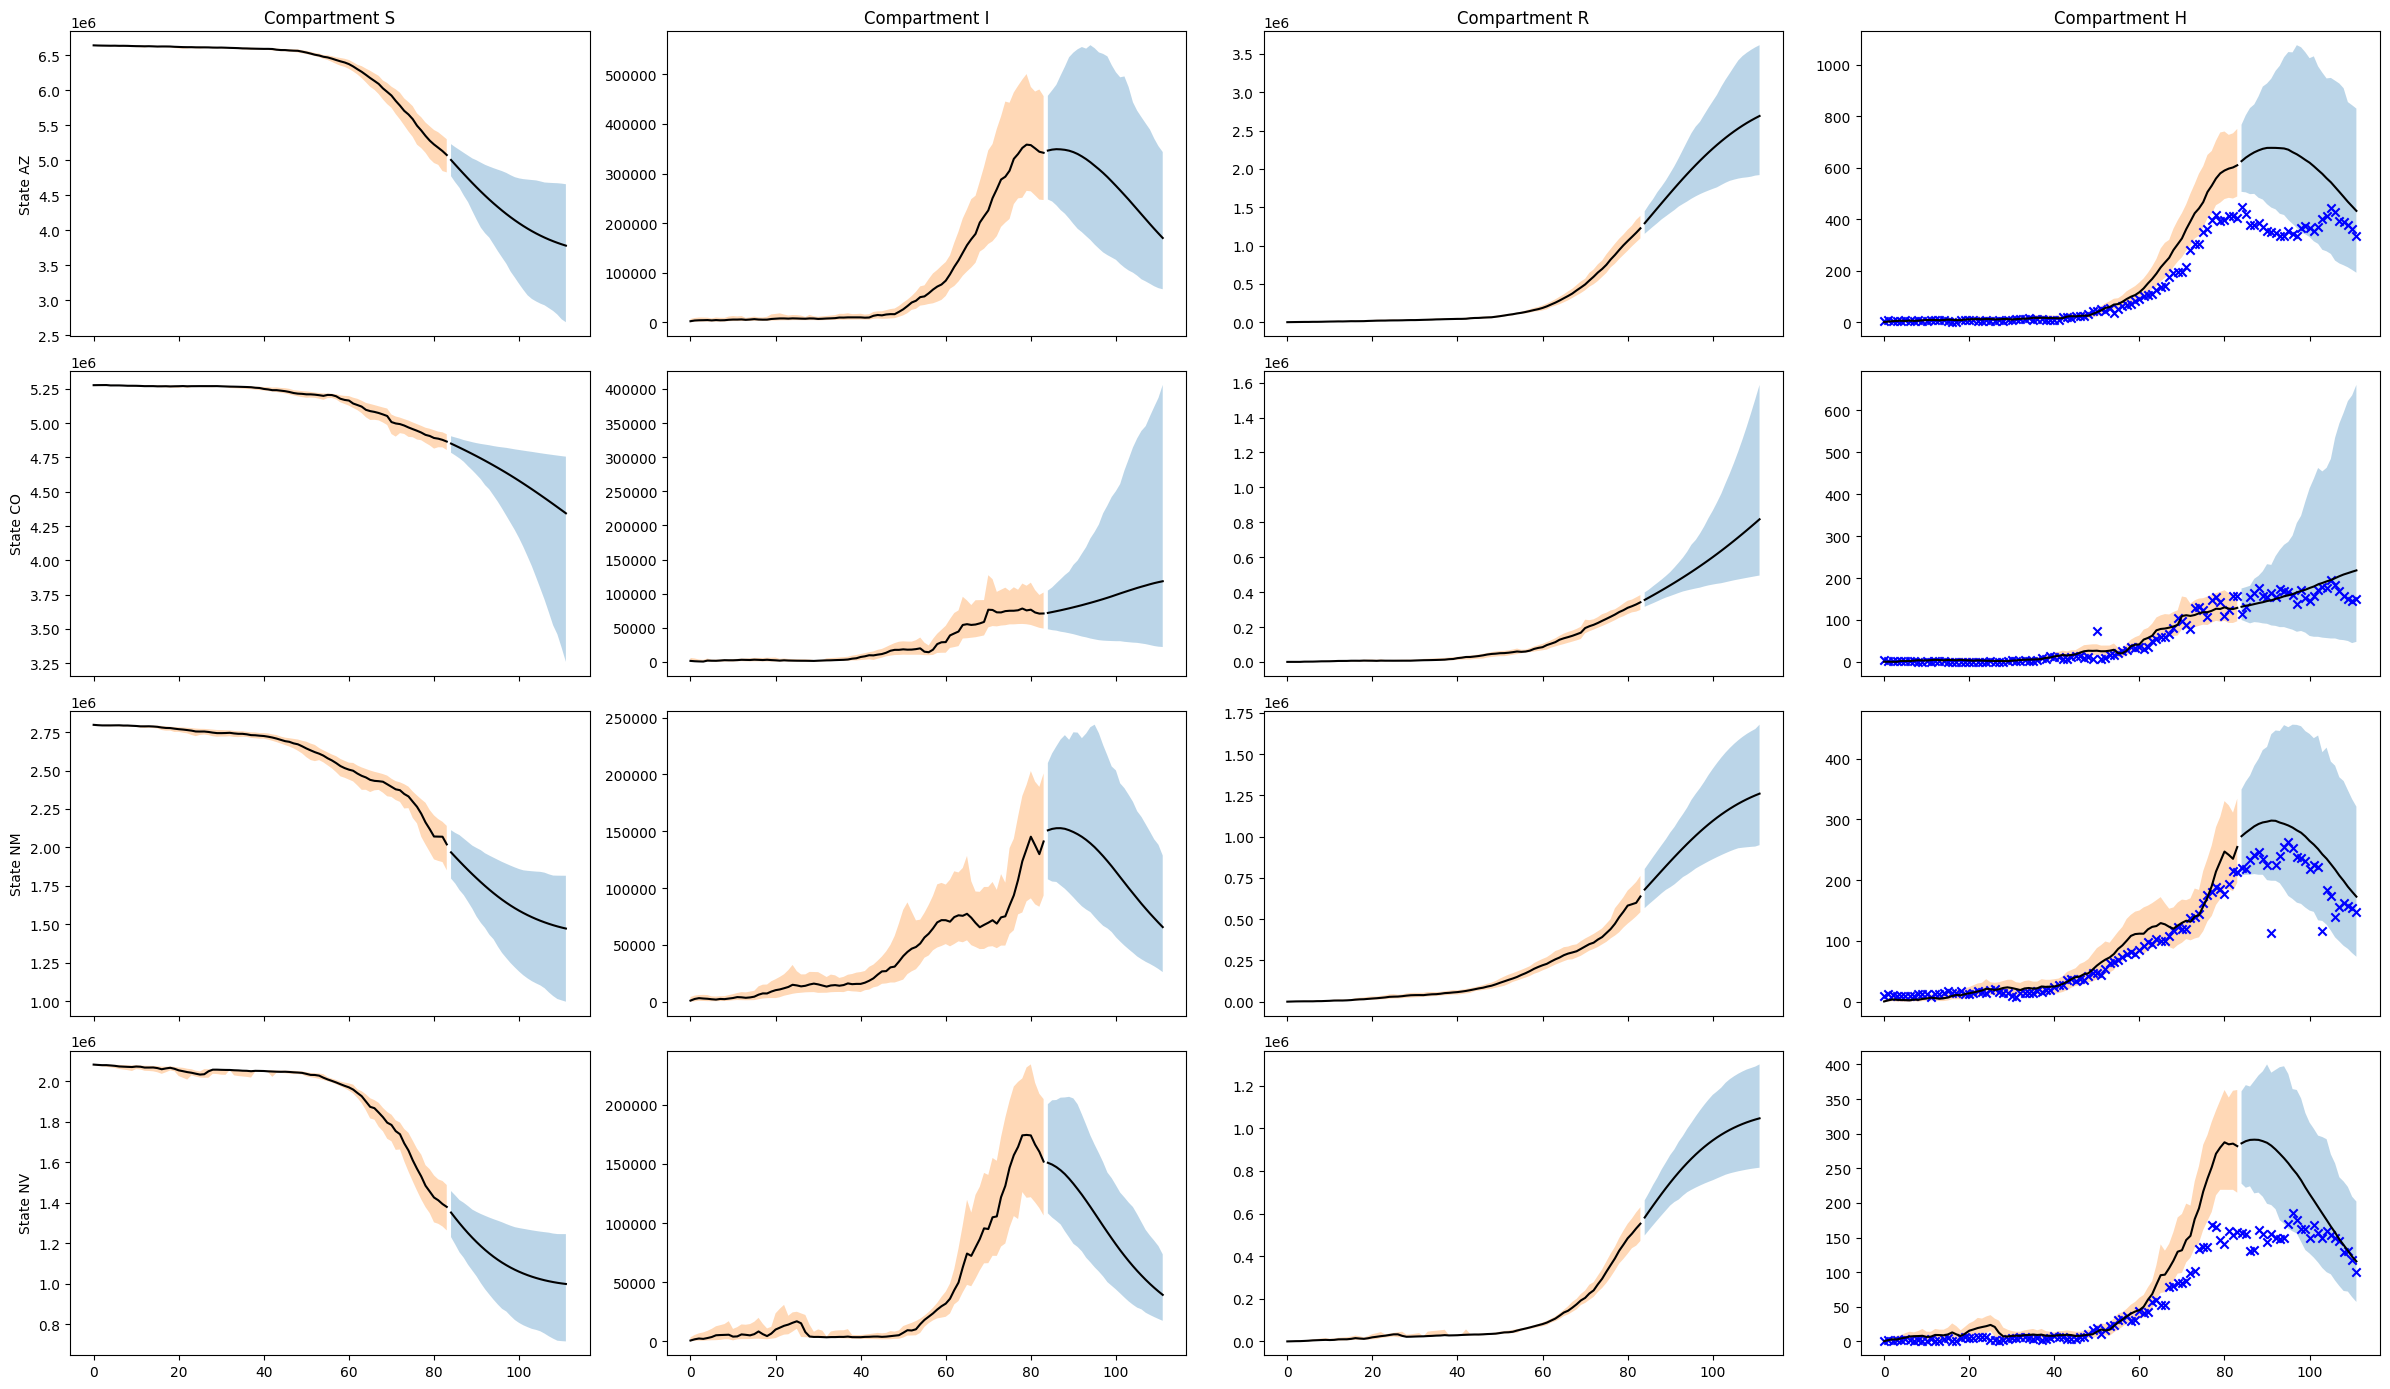

In [31]:
from math import ceil


data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(rume.time_frame.days,rume.time_frame.days + extend_duration,1)
total_date_range = np.arange(0,rume.time_frame.days + extend_duration,1)

n = len(states)
cols = 2
rows = ceil(n / cols)

a = forecast_output.compartments.shape[3]   # = 4
compartment_labels = ['S','I','R','H']

rows = n                       # one row per state
cols = a                       # one column per last-axis element

fig, axes = plt.subplots(rows, cols,
                         figsize=(6*cols, 3.5*rows),
                         sharex=True)

# ensure axes is 2-D even if n or a = 1
axes = np.atleast_2d(axes)

for i in range(n):               # loop states
    for k in range(a):           # loop final-axis components
        ax = axes[i, k]

        forecast_data = forecast_output.compartments[:, :, i, k]
        pf_data = particle_filter_output.compartments[:, :, i, k]

        lower_forecast = np.percentile(forecast_data, 2.5, axis=0).squeeze()
        upper_forecast = np.percentile(forecast_data, 97.5, axis=0).squeeze()
        mean_forecast  = np.mean(forecast_data, axis=0).squeeze()

        lower_pf = np.percentile(pf_data, 2.5, axis=0).squeeze()
        upper_pf = np.percentile(pf_data, 97.5, axis=0).squeeze()
        mean_pf  = np.mean(pf_data, axis=0).squeeze()

        ax.fill_between(sim_date_range, lower_forecast, upper_forecast, alpha=0.3)
        ax.plot(sim_date_range, mean_forecast, color='black')

        ax.fill_between(data_date_range, lower_pf, upper_pf, alpha=0.3)
        ax.plot(data_date_range, mean_pf, color='black')

        if(compartment_labels[k] == 'H'):
            ax.scatter(total_date_range,df_hosp[df_hosp['state'] == states[i]]['total_patients_hospitalized_confirmed_influenza'],color = 'blue',marker = 'x',label = 'real data')


        # Titles by row / col for readability
        if i == 0:
            ax.set_title(f'Compartment {compartment_labels[k]}')
        if k == 0:
            ax.set_ylabel(f'State {states[i]}')

plt.tight_layout()
plt.show()

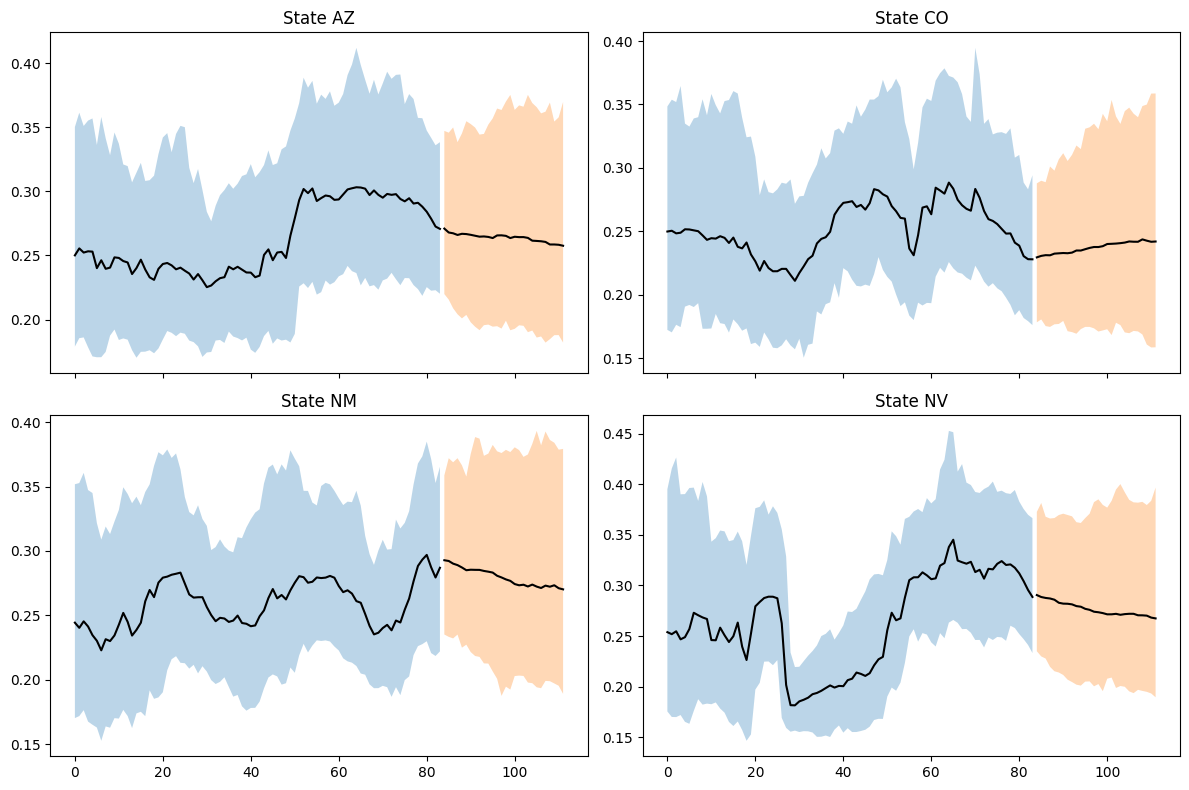

In [32]:
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

from epymorph.simulation import Context
from epymorph.attribute import NamePattern

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower_pf = np.percentile(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper_pf = np.percentile(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()
    mean_pf  = np.mean(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()

    lower_forecast = np.percentile(forecast_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper_forecast = np.percentile(forecast_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()
    mean_forecast  = np.mean(forecast_output.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()

    ax.fill_between(data_date_range, np.exp(lower_pf), np.exp(upper_pf), alpha=0.3, label='95% CI')
    ax.plot(data_date_range, np.exp(mean_pf), color='black', label='Mean of PF')
    ax.fill_between(sim_date_range, np.exp(lower_forecast), np.exp(upper_forecast), alpha=0.3, label='95% CI')
    ax.plot(sim_date_range, np.exp(mean_forecast), color='black', label='Mean of Forecast ')

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [33]:
columns = ['date','state','previous_day_admission_influenza_confirmed']

df_data = csv_data[csv_data['state'].isin(states)][columns].copy()
df_data['date'] = pd.to_datetime(df_data['date'])

df_data = df_data.sort_values('date')
df_data = df_data.reset_index(drop = True)

df_data = df_data[df_data['date'].isin(tf)][columns]

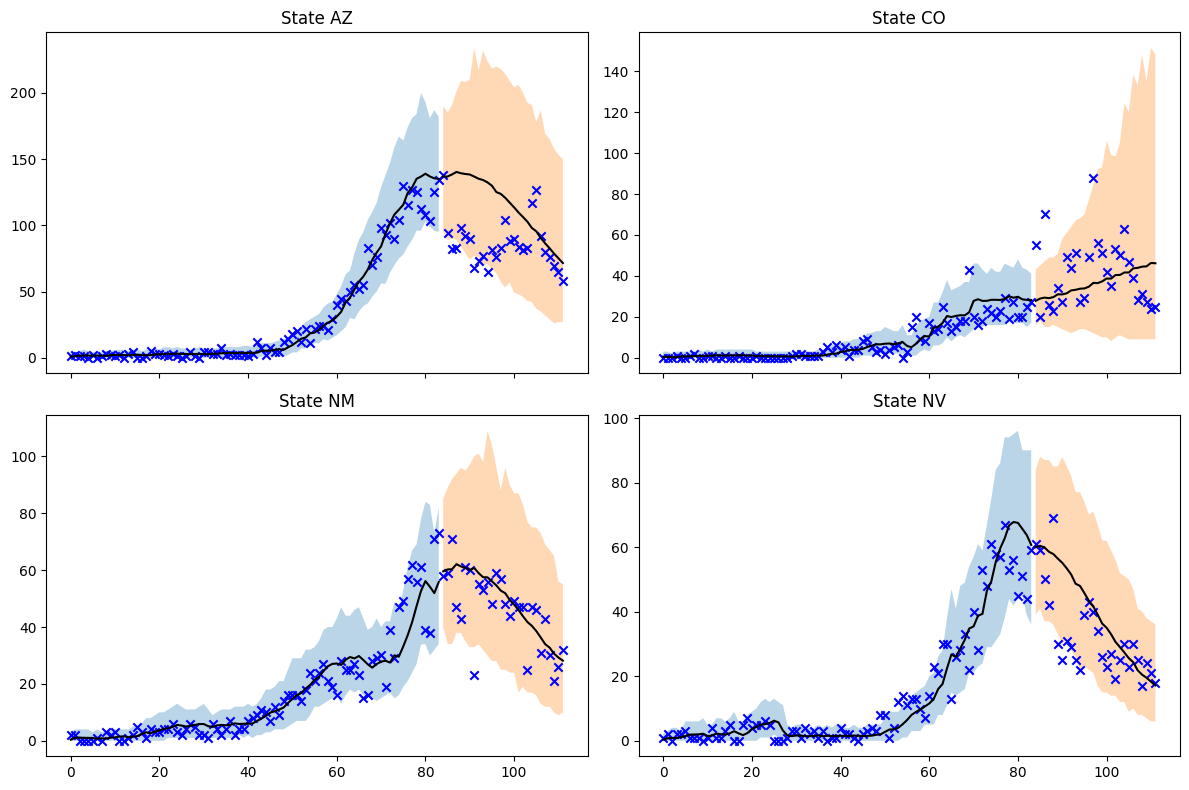

In [34]:
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower_pf = np.percentile(particle_filter_output.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_pf = np.percentile(particle_filter_output.events[:, :, i, 1], 97.5, axis=0).squeeze()
    mean_pf  = np.mean(particle_filter_output.events[:, :, i, 1], axis=0).squeeze()

    lower_forecast = np.percentile(forecast_output.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_forecast = np.percentile(forecast_output.events[:, :, i, 1], 97.5, axis=0).squeeze()
    mean_forecast  = np.mean(forecast_output.events[:, :, i, 1], axis=0).squeeze()

    ax.fill_between(data_date_range, lower_pf, upper_pf, alpha=0.3, label='95% CI')
    ax.plot(data_date_range, mean_pf, color='black', label='Mean of PF')

    ax.fill_between(sim_date_range, lower_forecast, upper_forecast, alpha=0.3, label='95% CI')
    ax.plot(sim_date_range, mean_forecast, color='black', label='Mean of PF')

    ax.scatter(total_date_range,df_data[df_data['state'] == states[i]]['previous_day_admission_influenza_confirmed'],color = 'blue',marker = 'x',label = 'real data')

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.tight_layout()

In [35]:
'''Now we compare to the forecast with weekly sum data. '''

'Now we compare to the forecast with weekly sum data. '

In [36]:

from epymorph.adrio.cdc import InfluenzaStateHospitalization


observations_weekly = Observations(
    source=InfluenzaStateHospitalization(),
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I->H"),
        time=rume.time_frame.select.all().group(EveryNDays(7)).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=Poisson(),
)

In [37]:
particle_filter_simulator_weekly = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations_weekly,
        save_trajectories=True,
    )

In [38]:
particle_filter_output_weekly = particle_filter_simulator_weekly.run(rng=rng)

Observation: 0, Label: 2022-09-15, Time Frame: 2022-09-15/2022-09-21 (7D), 
Observation: 1, Label: 2022-09-22, Time Frame: 2022-09-22/2022-09-28 (7D), 
Observation: 2, Label: 2022-09-29, Time Frame: 2022-09-29/2022-10-05 (7D), 
Observation: 3, Label: 2022-10-06, Time Frame: 2022-10-06/2022-10-12 (7D), 
Observation: 4, Label: 2022-10-13, Time Frame: 2022-10-13/2022-10-19 (7D), 
Observation: 5, Label: 2022-10-20, Time Frame: 2022-10-20/2022-10-26 (7D), 
Observation: 6, Label: 2022-10-27, Time Frame: 2022-10-27/2022-11-02 (7D), 
Observation: 7, Label: 2022-11-03, Time Frame: 2022-11-03/2022-11-09 (7D), 
Observation: 8, Label: 2022-11-10, Time Frame: 2022-11-10/2022-11-16 (7D), 
Observation: 9, Label: 2022-11-17, Time Frame: 2022-11-17/2022-11-23 (7D), 
Observation: 10, Label: 2022-11-24, Time Frame: 2022-11-24/2022-11-30 (7D), 
Observation: 11, Label: 2022-12-01, Time Frame: 2022-12-01/2022-12-07 (7D), 


In [39]:
from epymorph.forecasting.pipeline import FromOutput

forecast_simulator_weekly = ForecastSimulator(FromOutput(particle_filter_output_weekly,extend_duration))

In [40]:
forecast_simulator_weekly_output = forecast_simulator_weekly.run(rng = rng)

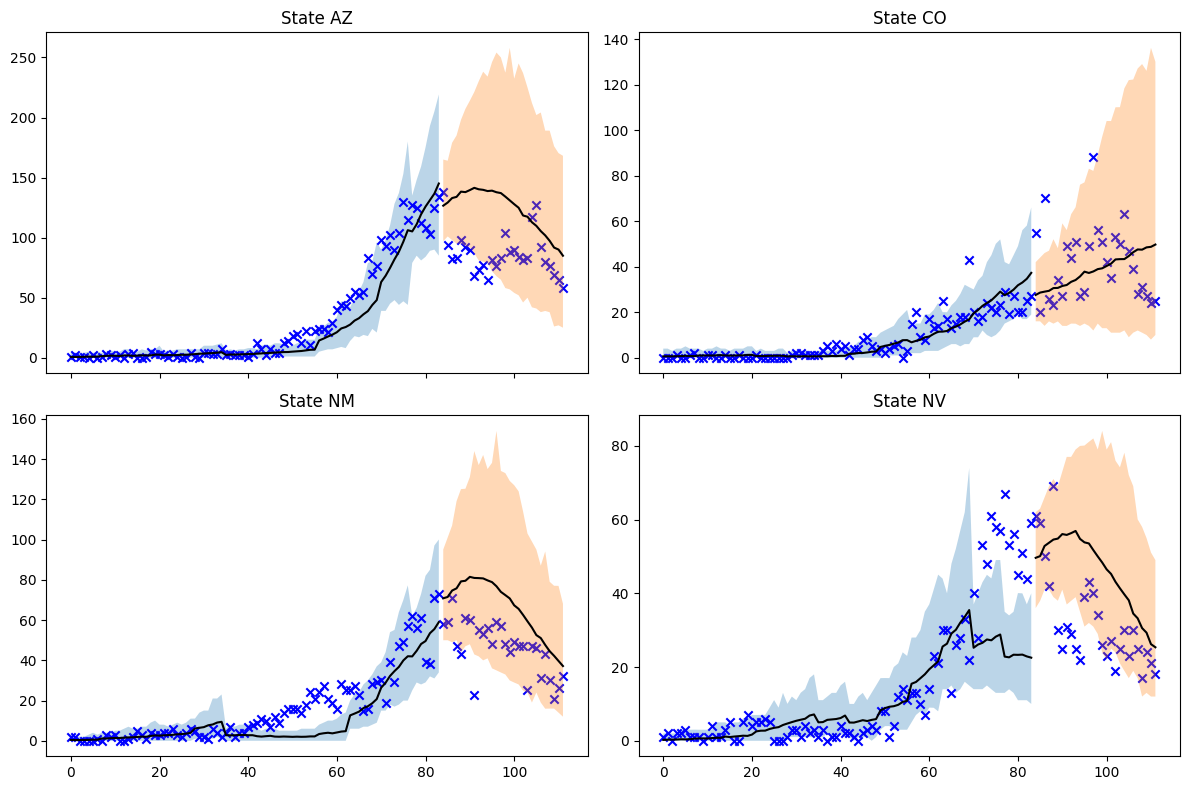

In [41]:
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(rume.time_frame.days,rume.time_frame.days + extend_duration,1)
total_date_range = np.arange(0,rume.time_frame.days + extend_duration,1)

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower_pf = np.percentile(particle_filter_output_weekly.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_pf = np.percentile(particle_filter_output_weekly.events[:, :, i, 1], 97.5, axis=0).squeeze()
    mean_pf  = np.mean(particle_filter_output_weekly.events[:, :, i, 1], axis=0).squeeze()

    lower_forecast = np.percentile(forecast_simulator_weekly_output.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_forecast = np.percentile(forecast_simulator_weekly_output.events[:, :, i, 1], 97.5, axis=0).squeeze()
    mean_forecast  = np.mean(forecast_simulator_weekly_output.events[:, :, i, 1], axis=0).squeeze()

    ax.fill_between(data_date_range,lower_pf, upper_pf, alpha=0.3, label='95% CI')
    ax.plot(data_date_range,mean_pf, color='black', label='Mean of PF')

    ax.scatter(total_date_range,df_data[df_data['state'] == states[i]]['previous_day_admission_influenza_confirmed'],color = 'blue',marker = 'x',label = 'real data')


    ax.fill_between(sim_date_range,lower_forecast, upper_forecast, alpha=0.3, label='95% CI')
    ax.plot(sim_date_range,mean_forecast, color='black', label='Mean of PF')

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.tight_layout()

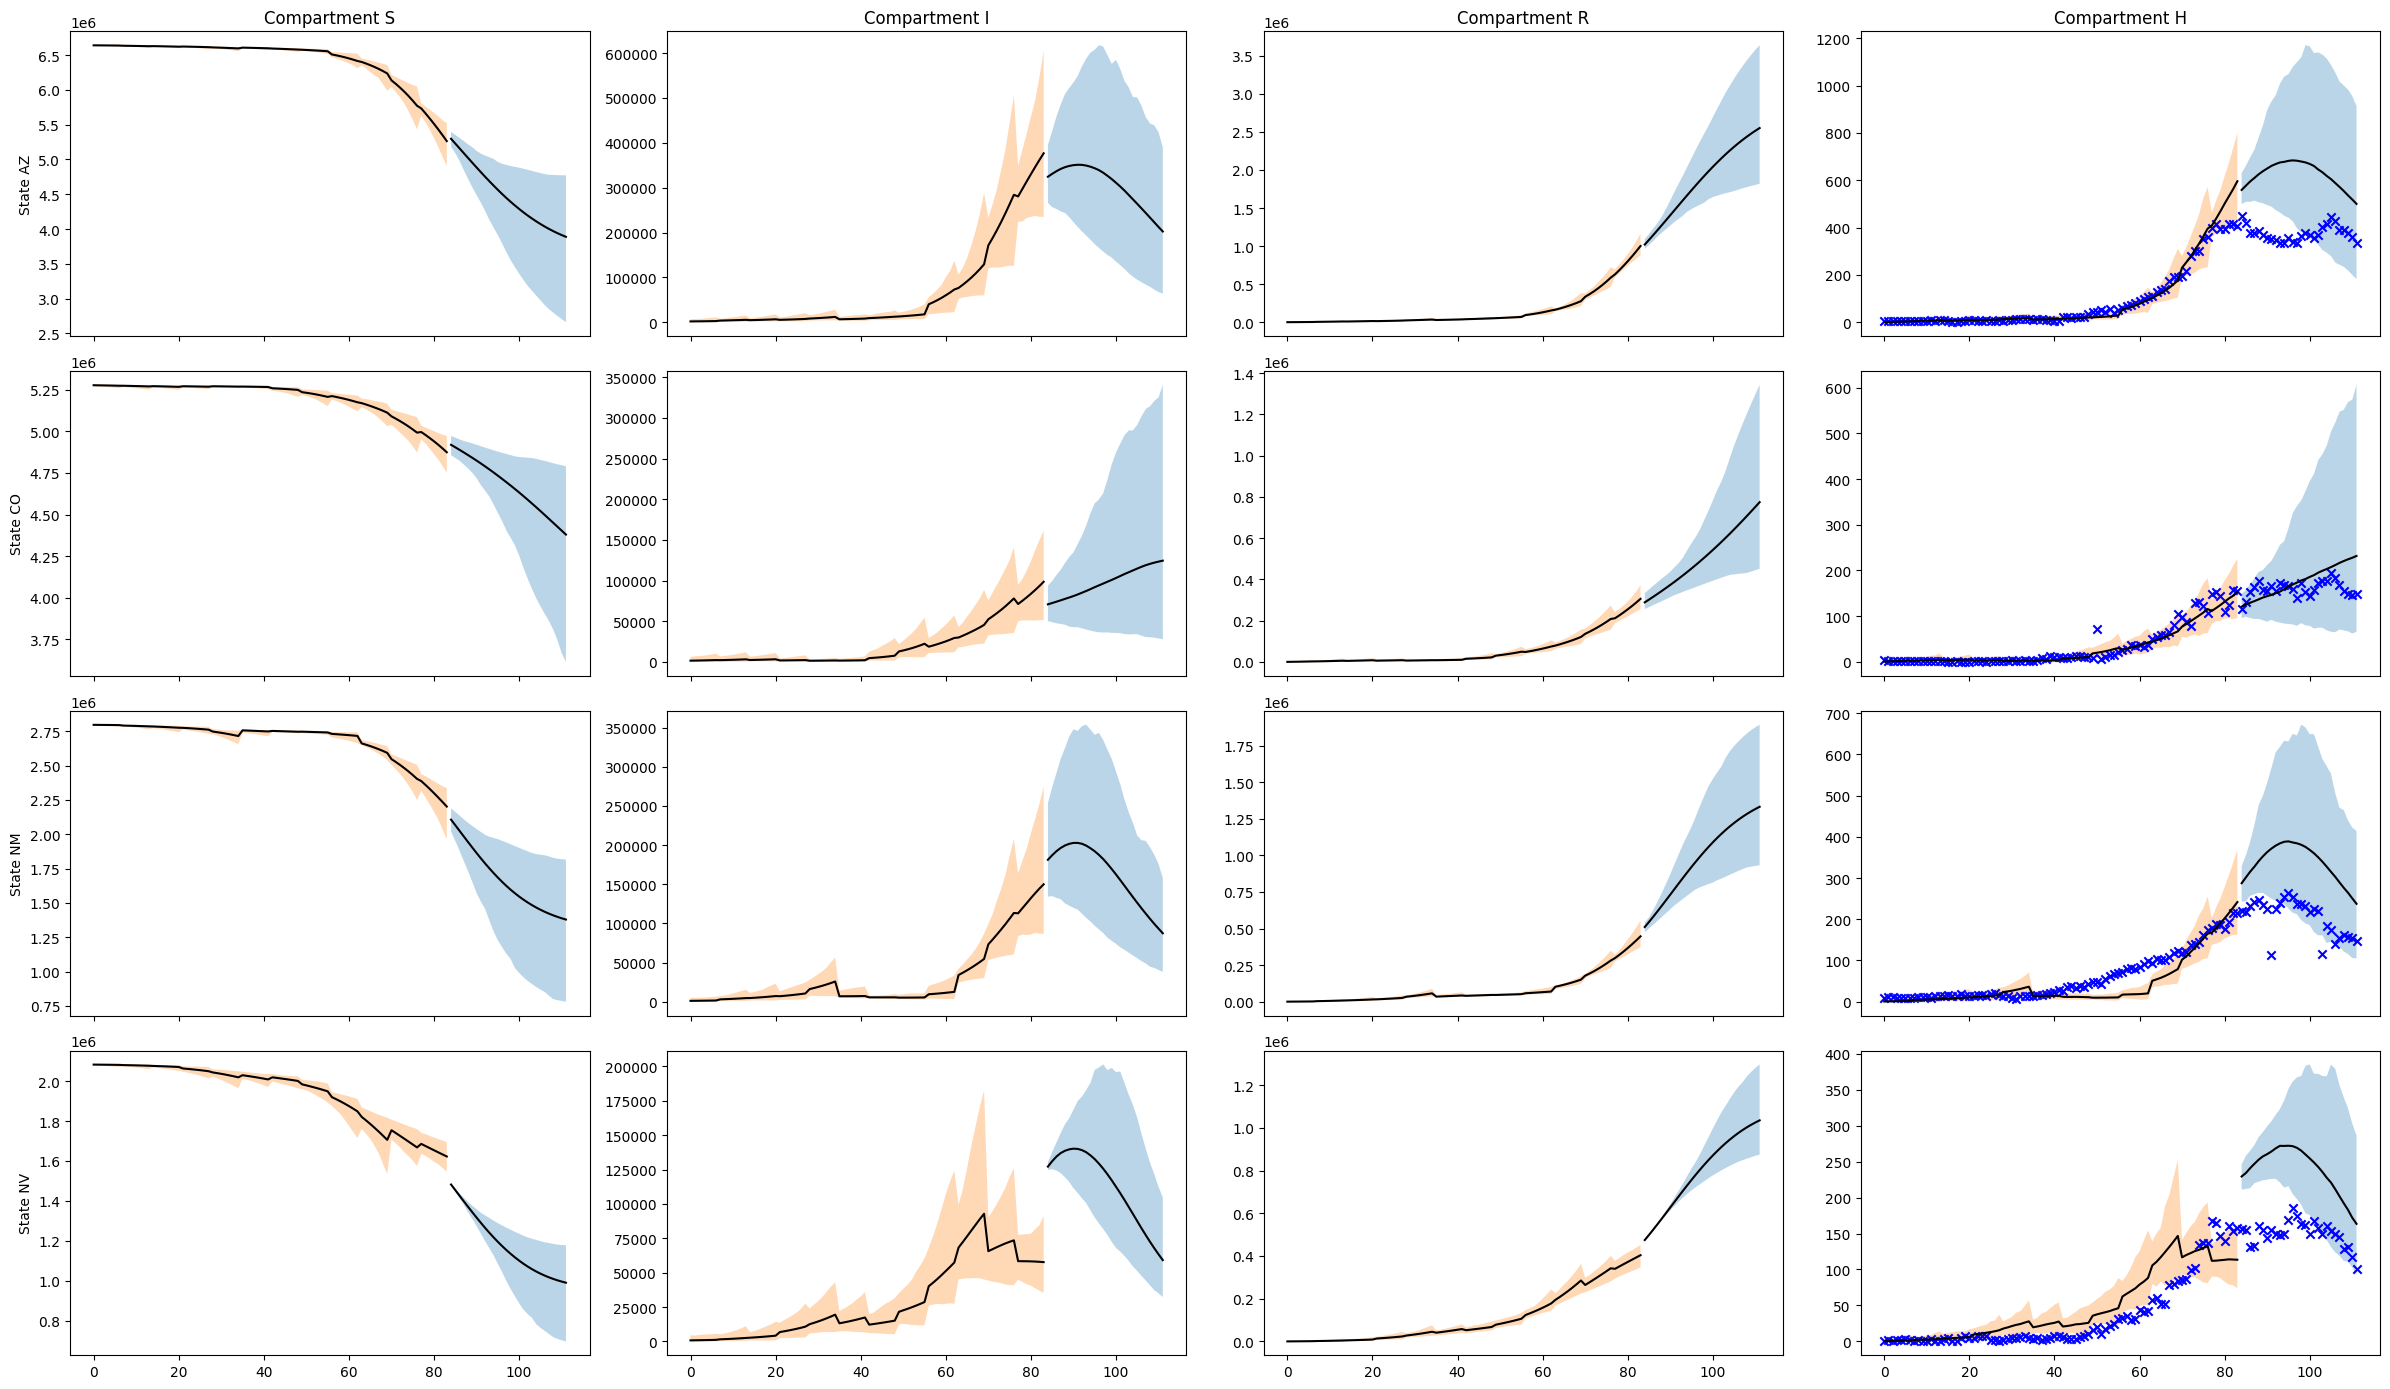

In [42]:
n = len(states)
cols = 2
rows = ceil(n / cols)

a = forecast_simulator_weekly_output.compartments.shape[3]   # = 4
compartment_labels = ['S','I','R','H']

rows = n                       # one row per state
cols = a                       # one column per last-axis element

fig, axes = plt.subplots(rows, cols,
                         figsize=(6*cols, 3.5*rows),
                         sharex=True)

# ensure axes is 2-D even if n or a = 1
axes = np.atleast_2d(axes)

for i in range(n):               # loop states
    for k in range(a):           # loop final-axis components
        ax = axes[i, k]

        forecast_data = forecast_simulator_weekly_output.compartments[:, :, i, k]
        pf_data = particle_filter_output_weekly.compartments[:, :, i, k]

        lower_forecast = np.percentile(forecast_data, 2.5, axis=0).squeeze()
        upper_forecast = np.percentile(forecast_data, 97.5, axis=0).squeeze()
        mean_forecast  = np.mean(forecast_data, axis=0).squeeze()

        lower_pf = np.percentile(pf_data, 2.5, axis=0).squeeze()
        upper_pf = np.percentile(pf_data, 97.5, axis=0).squeeze()
        mean_pf  = np.mean(pf_data, axis=0).squeeze()

        ax.fill_between(sim_date_range, lower_forecast, upper_forecast, alpha=0.3)
        ax.plot(sim_date_range, mean_forecast, color='black')

        ax.fill_between(data_date_range, lower_pf, upper_pf, alpha=0.3)
        ax.plot(data_date_range, mean_pf, color='black')

        if(compartment_labels[k] == 'H'):
            ax.scatter(total_date_range,df_hosp[df_hosp['state'] == states[i]]['total_patients_hospitalized_confirmed_influenza'],color = 'blue',marker = 'x',label = 'real data')


        # Titles by row / col for readability
        if i == 0:
            ax.set_title(f'Compartment {compartment_labels[k]}')
        if k == 0:
            ax.set_ylabel(f'State {states[i]}')

plt.tight_layout()
plt.show()

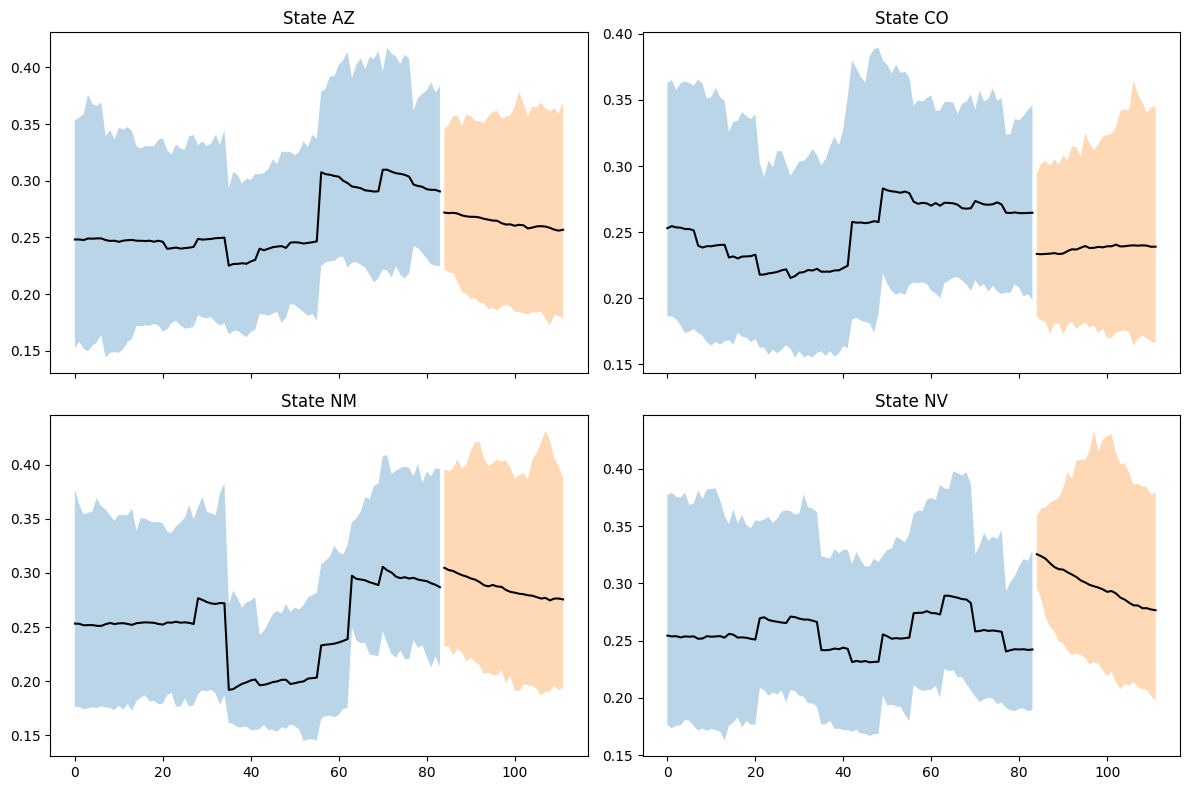

In [43]:
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower_pf = np.percentile(particle_filter_output_weekly.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper_pf = np.percentile(particle_filter_output_weekly.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()
    mean_pf  = np.mean(particle_filter_output_weekly.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()

    lower_forecast = np.percentile(forecast_simulator_weekly_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper_forecast = np.percentile(forecast_simulator_weekly_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()
    mean_forecast  = np.mean(forecast_simulator_weekly_output.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()

    ax.fill_between(data_date_range, np.exp(lower_pf), np.exp(upper_pf), alpha=0.3, label='95% CI')
    ax.plot(data_date_range, np.exp(mean_pf), color='black', label='Mean of PF')
    ax.fill_between(sim_date_range, np.exp(lower_forecast), np.exp(upper_forecast), alpha=0.3, label='95% CI')
    ax.plot(sim_date_range, np.exp(mean_forecast), color='black', label='Mean of Forecast ')

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()